In [47]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from dynamax.hidden_markov_model import LinearAutoregressiveHMM
from dynamax.utils.plotting import gradient_cmap
from dynamax.utils.utils import random_rotation

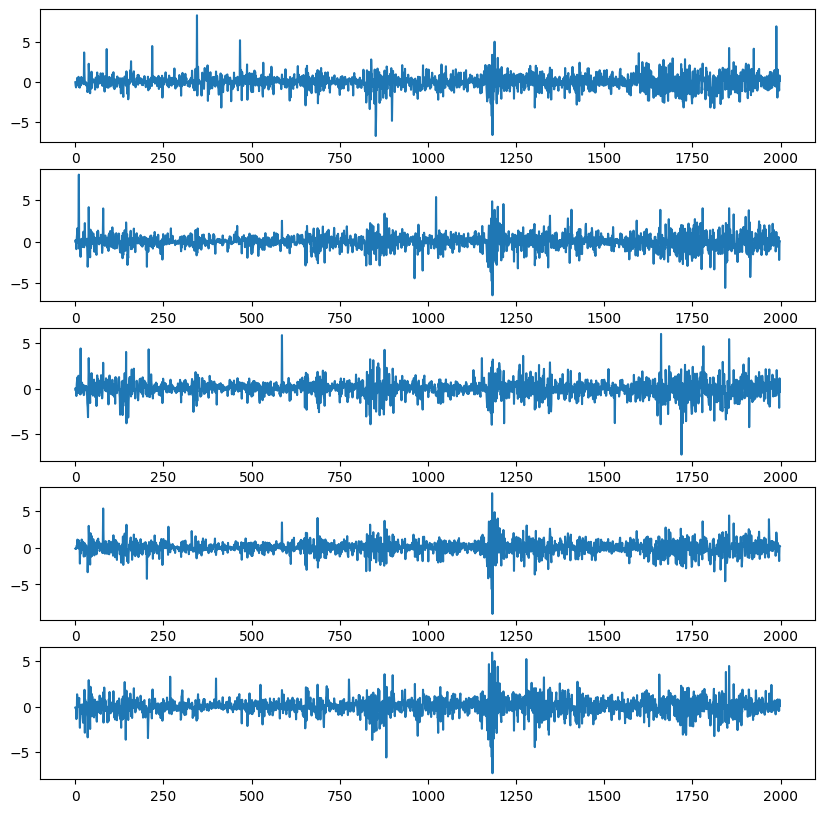

In [48]:
data_META = pd.read_csv("Financial-Data/stocks/NVDA.csv")
data_GOOG = pd.read_csv("Financial-Data/stocks/GOOG.csv")
data_AMZN = pd.read_csv("Financial-Data/stocks/AMZN.csv")
data_MSFT = pd.read_csv("Financial-Data/stocks/MSFT.csv")
data_AAPL = pd.read_csv("Financial-Data/stocks/AAPL.csv")
names=['Nvidia', 'Google', 'Amazon', 'Microsoft', 'Apple']

data_list = [data_META, data_GOOG, data_AMZN, data_MSFT, data_AAPL]

n_obs = 2000
data_close_list = [data['Close'].iloc[-n_obs:].values for data in data_list]

log_ret_list = [np.diff(np.log(data_close)) for data_close in data_close_list]

log_ret_norm_list = [(log_ret - np.mean(log_ret)) / np.std(log_ret) for log_ret in log_ret_list]


# Plot log returns on different plots
fig, ax = plt.subplots(len(log_ret_norm_list), 1, figsize=(10, 10))
for i, data in enumerate(log_ret_norm_list):
    ax[i].plot(data)


plt.show()


/home/saradsai/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


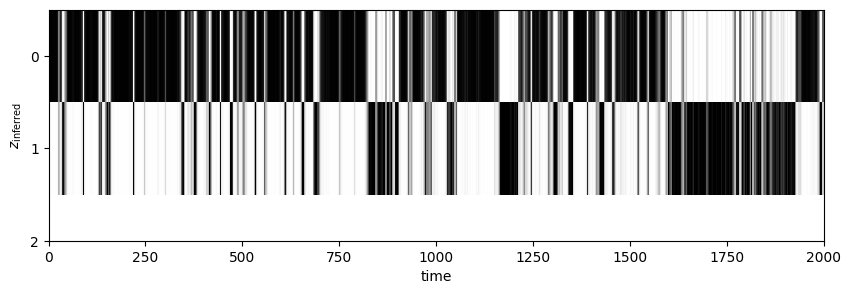

/home/saradsai/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


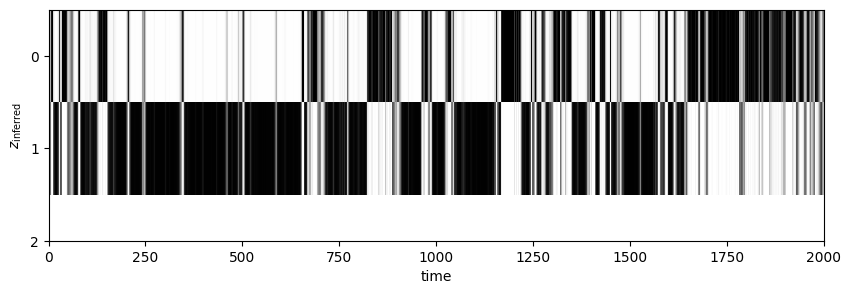

/home/saradsai/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


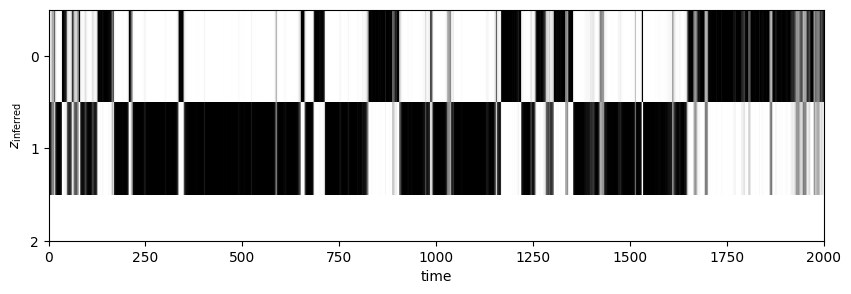

/home/saradsai/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


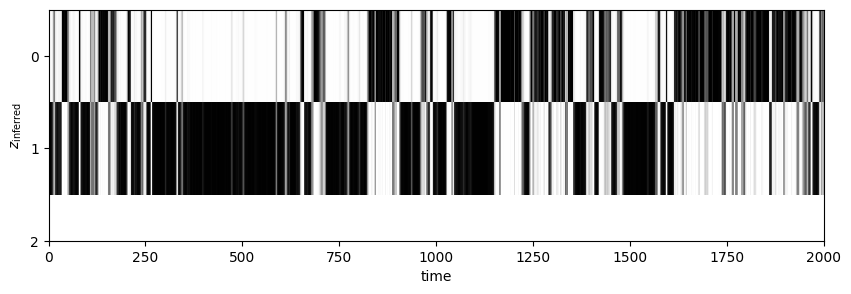

/home/saradsai/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


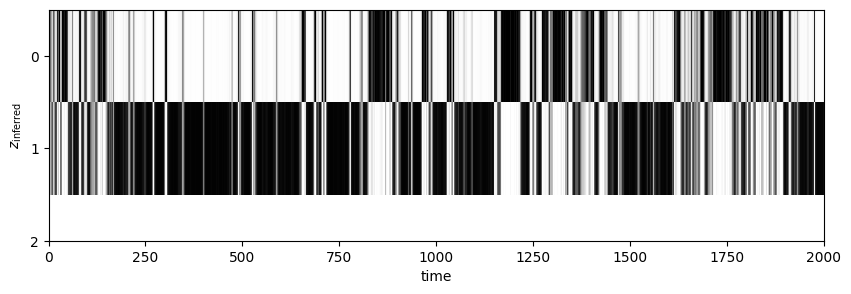

In [49]:
most_likely_states_list = []

for data in log_ret_norm_list:  
    num_states = 2
    emissions = np.array(data).reshape(-1, 1)
    # inputs are shifted emissions
    emission_dim = 1
    num_lags = 10

    # Now fit an HMM to the emissions
    key1, key2 = jr.split(jr.PRNGKey(0), 2)
    test_num_states = num_states

    # Initialize with K-Means
    arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags)
    params, props = arhmm.initialize(key=jr.PRNGKey(1), method="kmeans", emissions=emissions)
    inputs = arhmm.compute_inputs(emissions)
    # Fit with EM
    fitted_params, lps = arhmm.fit_em(params, props, emissions, inputs=inputs)
    posterior = arhmm.smoother(fitted_params, emissions, inputs=inputs)
    most_likely_states = arhmm.most_likely_states(fitted_params, emissions, inputs=inputs)
    most_likely_states_list.append(most_likely_states)
    plot_slice = (0, n_obs)
    plt.imshow(posterior.smoothed_probs.T, aspect="auto", interpolation="none", cmap="Greys", vmin=0, vmax=1)
    #Make the image shorter and wider
    plt.gcf().set_size_inches(10, 3)
    plt.xlim(plot_slice)
    plt.ylabel("$z_{\\mathrm{inferred}}$")
    plt.yticks([0,1,2])
    plt.xlabel("time")
    plt.show()


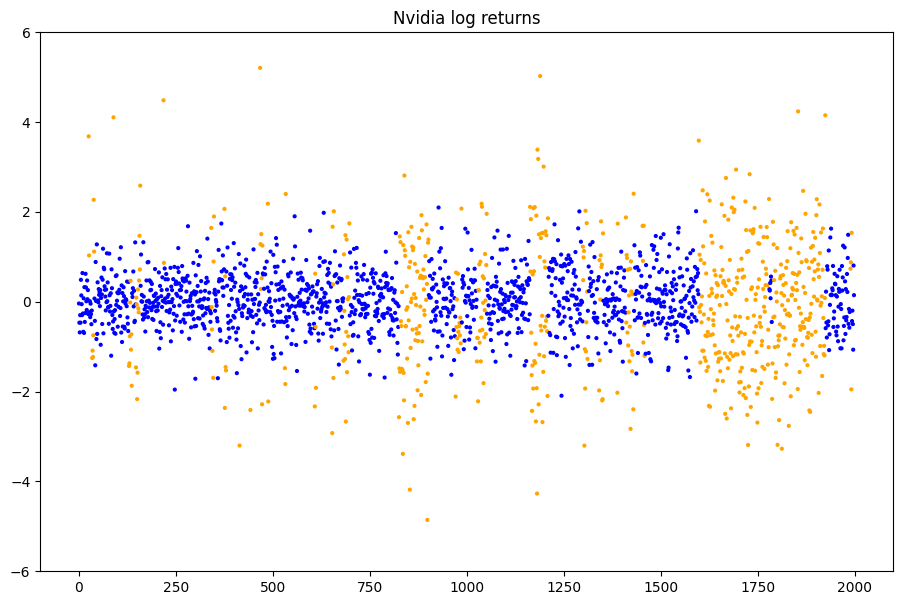

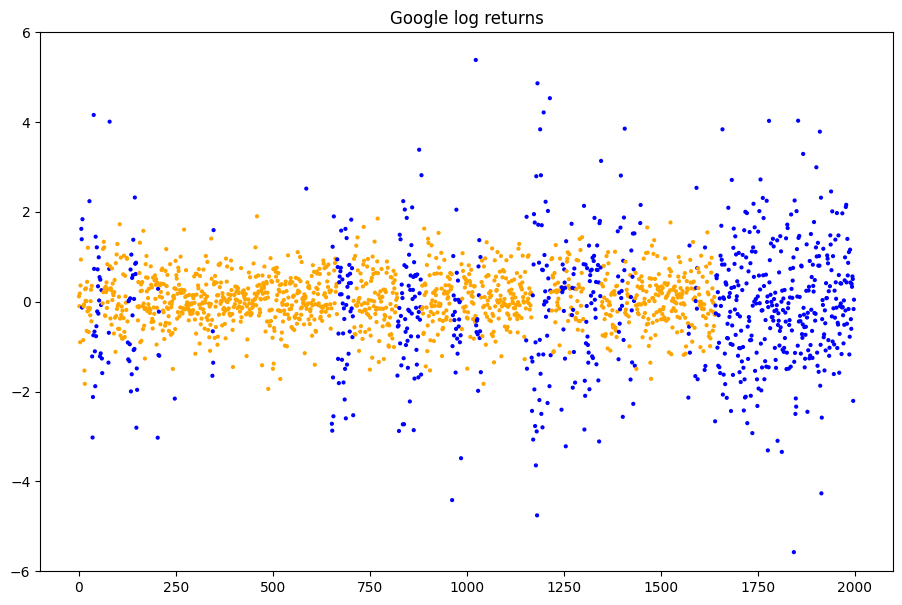

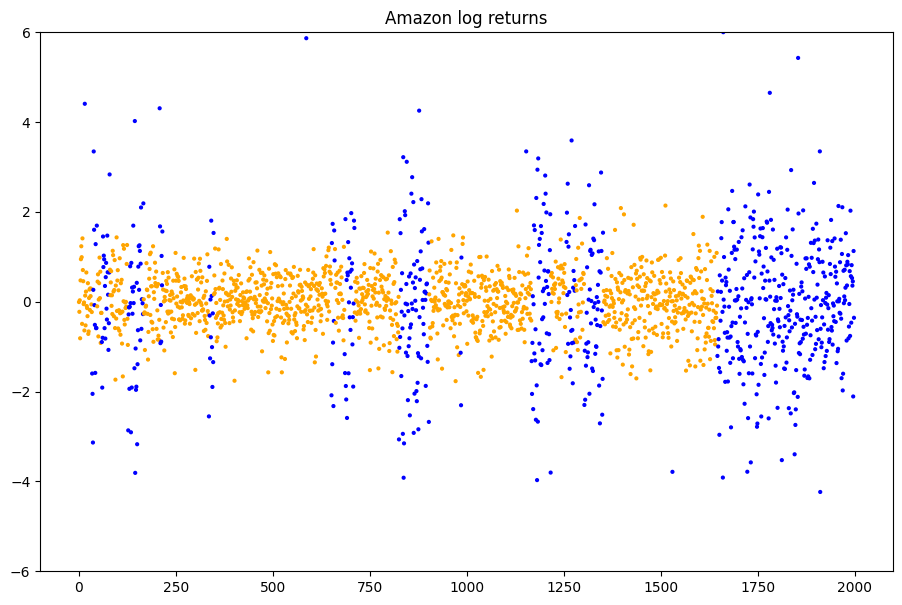

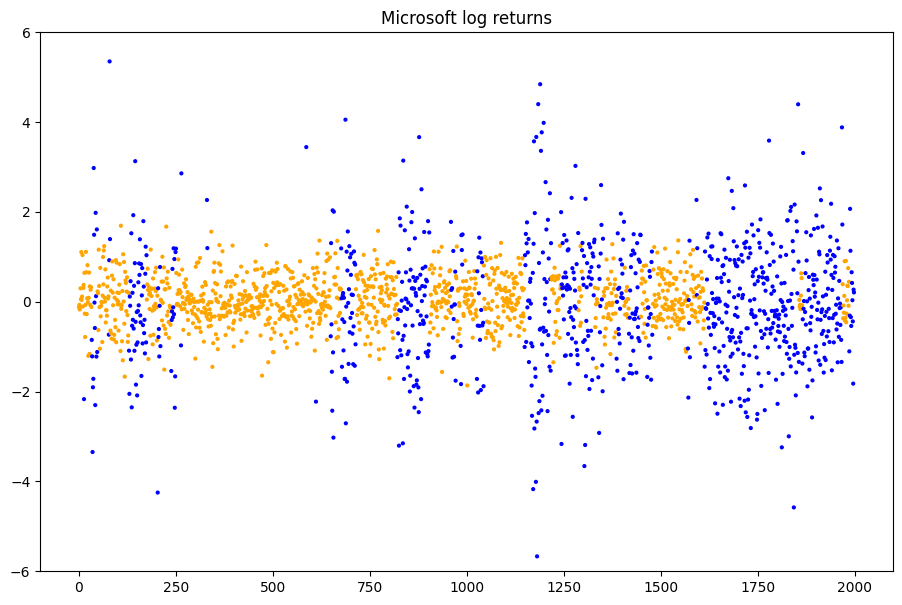

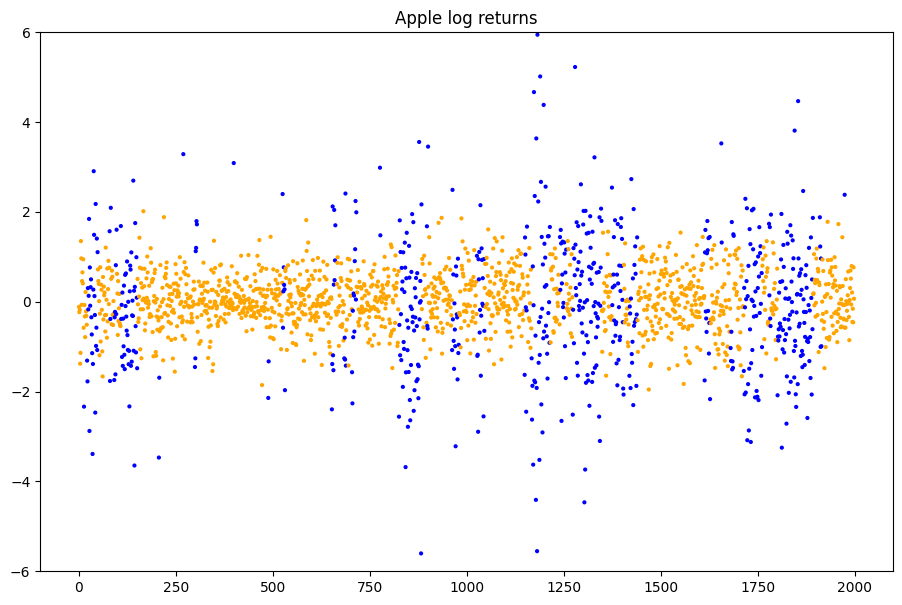

In [53]:
# Plot log returns on different plots

for i, data in enumerate(log_ret_norm_list):
    
    #set size
    plt.gcf().set_size_inches(11, 7)
    plt.title(names[i] + ' log returns')
    most_likely_states = most_likely_states_list[i]
    #scatter the points and color them according to the most likely state at that time
    colors = ["blue" if x == 0 else "orange" for x in most_likely_states]
    plt.scatter(range(len(data)), data, c=colors, s=4)

    #set y limits to be the same
    plt.ylim(-6, 6)
    plt.show()

    
plt.show()


In [51]:
for i in range(len(fitted_params)):
    print(fitted_params[i])

ParamsStandardHMMInitialState(probs=Array([0.13265574, 0.8673443 ], dtype=float32))
ParamsStandardHMMTransitions(transition_matrix=Array([[0.88007075, 0.11992928],
       [0.06310167, 0.93689835]], dtype=float32))
ParamsLinearRegressionHMMEmissions(weights=Array([[[-0.08977333, -0.04980209, -0.03073427, -0.05686327,
          0.04871783, -0.0793222 ,  0.10137291, -0.11803195,
          0.14539132, -0.05046619]],

       [[ 0.01991706, -0.01883661, -0.00060184,  0.01708656,
          0.00141178,  0.04963934,  0.02150314,  0.0012877 ,
          0.00066295,  0.00195459]]], dtype=float32), biases=Array([[-0.10911725],
       [ 0.04032535]], dtype=float32), covs=Array([[[2.0859685]],

       [[0.341126 ]]], dtype=float32))
